Using device: cuda
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train size: 40000, Val size: 10000, Test size: 10000
Epoch 01/20 | 77.9s | Train Loss 0.6127 Acc 79.03% | Val Loss 0.5377 Acc 82.18%
  ✅ Saved new best model (Val Acc = 82.18%)
Epoch 02/20 | 77.9s | Train Loss 0.4523 Acc 84.66% | Val Loss 0.4450 Acc 85.04%
  ✅ Saved new best model (Val Acc = 85.04%)
Epoch 03/20 | 77.9s | Train Loss 0.4102 Acc 86.06% | Val Loss 0.4878 Acc 83.90%
Epoch 04/20 | 78.8s | Train Loss 0.3806 Acc 87.13% | Val Loss 0.5046 Acc 83.04%
Epoch 05/20 | 78.9s | Train Loss 0.3671 Acc 87.50% | Val Loss 0.4493 Acc 84.99%
Epoch 06/20 | 78.5s | Train Loss 0.3538 Acc 87.93% | Val Loss 0.4525 Acc 84.84%
Epoch 07/20 | 78.0s | Train Loss 0.3415 Acc 88.23% | Val Loss 0.4901 Acc 83.66%
Epoch 08/20 | 77.6s | Train Loss 0.3356 Acc 88.62% | Val Loss 0.3663 Acc 87.57%
  ✅ Saved new best model (Val Acc = 87.57%)
Epoch 09/20 | 80.9s | Train Loss 0.3202 Acc 89.13% | Val

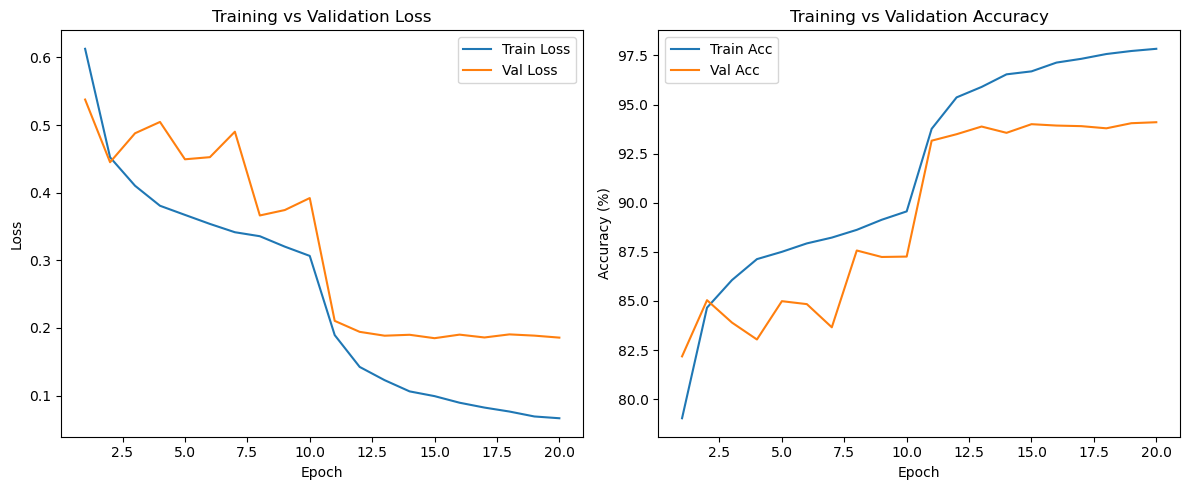


Best checkpoint → Test Loss 0.2005 | Test Acc 93.58%

Per-class accuracy:
airplane  : 94.00%
automobile: 97.20%
bird      : 91.70%
cat       : 84.60%
deer      : 93.90%
dog       : 91.70%
frog      : 96.10%
horse     : 96.00%
ship      : 96.50%
truck     : 94.10%

Classification report:
              precision    recall  f1-score   support

    airplane       0.94      0.94      0.94      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.92      0.92      0.92      1000
         cat       0.90      0.85      0.87      1000
        deer       0.94      0.94      0.94      1000
         dog       0.88      0.92      0.90      1000
        frog       0.94      0.96      0.95      1000
       horse       0.97      0.96      0.97      1000
        ship       0.95      0.96      0.96      1000
       truck       0.96      0.94      0.95      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighte

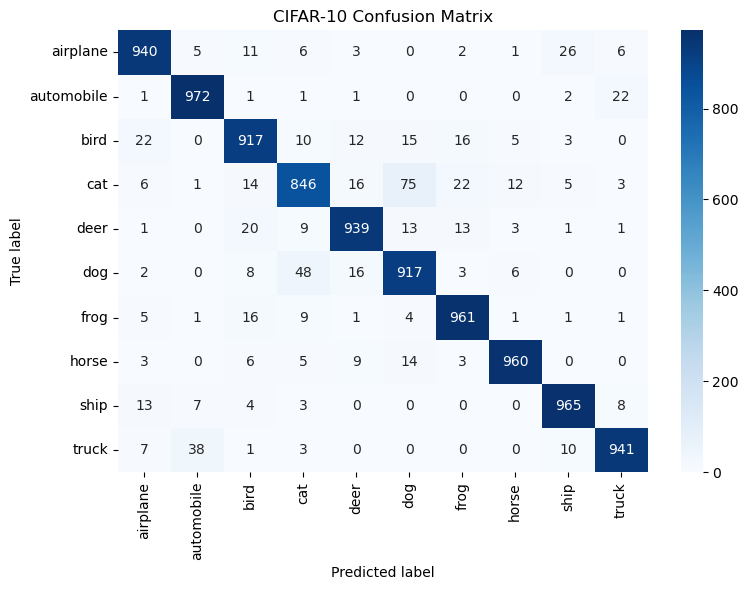

In [2]:
import torch
import math, random
from torch.utils.data import Sampler 
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torch.utils.data import Subset

class BalancedBatchSampler(Sampler):
    def __init__(self, targets, batch_size, num_classes):
        assert batch_size % num_classes == 0, "batch_size must be divisible by num_classes"
        self.targets = list(map(int, targets))
        self.num_classes = num_classes
        self.per_class = batch_size // num_classes

        # build index lists per class
        self.class_to_indices = {c: [] for c in range(num_classes)}
        for idx, y in enumerate(self.targets):
            self.class_to_indices[y].append(idx)

        self.max_class_len = max(len(v) for v in self.class_to_indices.values())

    def __iter__(self):
        # shuffle indices within each class every epoch
        pools = {}
        for c, idxs in self.class_to_indices.items():
            idxs = idxs.copy()
            random.shuffle(idxs)
            # repeat if needed so all classes can yield equally many mini-batches
            reps = math.ceil(self.max_class_len / len(idxs))
            pools[c] = (idxs * reps)

        # yield balanced batches
        ptr = {c: 0 for c in range(self.num_classes)}
        while True:
            batch = []
            for c in range(self.num_classes):
                start = ptr[c]
                end = start + self.per_class
                if end > len(pools[c]):
                    return  # epoch end
                batch.extend(pools[c][start:end])
                ptr[c] = end
            yield batch

    def __len__(self):
        # number of full balanced batches per epoch
        return (self.max_class_len // self.per_class) * self.num_classes


########################################
# Config
########################################
data_root = r"C:\Users\ADMIN\Downloads\cifar-10-python.tar\cifar-10-python"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 120
EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 5e-4
VAL_SPLIT = 0.2   # 40k train / 10k val

########################################
# Transforms (Resize to 224x224)
########################################
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

########################################
# Datasets
########################################
full_train_dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    transform=train_transform,
    download=False
)

test_dataset = datasets.CIFAR10(
    root=data_root,
    train=False,
    transform=test_transform,
    download=False
)

classes = full_train_dataset.classes
print("Classes:", classes)

########################################
# Train/Val split
#######################################
n_train = int((1 - VAL_SPLIT) * len(datasets.CIFAR10(root=data_root, train=True, download=False)))
n_val   = len(datasets.CIFAR10(root=data_root, train=True, download=False)) - n_train
train_idx, val_idx = torch.utils.data.random_split(range(50000), [n_train, n_val])

base_train = datasets.CIFAR10(root=data_root, train=True,  transform=train_transform, download=False)
base_val   = datasets.CIFAR10(root=data_root, train=True,  transform=test_transform,  download=False)

train_dataset = Subset(base_train, train_idx.indices if hasattr(train_idx, "indices") else train_idx)
val_dataset   = Subset(base_val,   val_idx.indices   if hasattr(val_idx,   "indices")   else val_idx)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

########################################
#  BalancedBatchSampler for TRAIN subset only
########################################
train_targets = [base_train.targets[i] for i in train_dataset.indices]
balanced_sampler = BalancedBatchSampler(train_targets, batch_size=BATCH_SIZE, num_classes=10)

########################################
# Dataloaders
########################################
train_loader = DataLoader(
    train_dataset,
    batch_sampler=balanced_sampler,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

########################################
# Model: ResNet-18 imagenet adapted for CIFAR-10 (224 x224)
########################################
model = resnet18(weights="IMAGENET1K_V1")


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

########################################
# Loss, Optimizer, Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

########################################
# Train / Eval helpers
########################################
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def evaluate(model, loader, criterion, return_preds=False):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if return_preds:
                all_labels.append(labels.cpu())
                all_preds.append(preds.cpu())

    if return_preds:
        return running_loss / total, correct / total, torch.cat(all_labels), torch.cat(all_preds)

    return running_loss / total, correct / total

########################################
# Training loop (model chosen by Val Acc)
########################################
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | {dt:.1f}s | "
          f"Train Loss {train_loss:.4f} Acc {train_acc*100:.2f}% | "
          f"Val Loss {val_loss:.4f} Acc {val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "resnet18_cifar10_best_val_sampling.pth")
        print(f"  ✅ Saved new best model (Val Acc = {best_val_acc*100:.2f}%)")

print(f"\nTraining complete. Best Val Acc: {best_val_acc*100:.2f}%")

########################################
# Plot Training vs Validation Curves
########################################
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# ---- Loss curve ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# ---- Accuracy curve ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [a*100 for a in train_accs], label='Train Acc')
plt.plot(epochs_range, [a*100 for a in val_accs], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



########################################
# Final Test Evaluation (unseen test set)
########################################
best_model = resnet18(weights=None)
num_ftrs = best_model.fc.in_features 
best_model.fc = nn.Linear(num_ftrs, 10)
best_model = best_model.to(device)

best_model.load_state_dict(torch.load("resnet18_cifar10_best_val_sampling.pth", map_location=device))

test_loss, test_acc, all_labels, all_preds = evaluate(
    best_model, test_loader, criterion, return_preds=True
)

print(f"\nBest checkpoint → Test Loss {test_loss:.4f} | Test Acc {test_acc*100:.2f}%")

cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("\nPer-class accuracy:")
for i, cls in enumerate(classes):
    print(f"{cls:10s}: {per_class_acc[i]*100:.2f}%")

print("\nClassification report:")
print(classification_report(all_labels.numpy(), all_preds.numpy(), target_names=classes))

########################################
# Plot Confusion Matrix
########################################
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix")
plt.tight_layout()
plt.show()

